This Notebook downloads Landsat scenes using EOdal

Script to extract a collection of Landsat scenes for a
custom area of interest (AOI).

The script shows how to use the EOdal Mapper class that takes over
data handling such as

* querying of spatio-temporal metadata catalogs to identify
available Landsat scenes
* merging data from different tiles if required
* re-projection of imagery from one UTM zone into another if required
* removal of black-filled (i.e., no-data) scenes

This script works by retrieving Landsat Collection-2 scenes from
Microsoft Planetary Computer (https://planetarycomputer.microsoft.com).
This requires no authentication required. Alternatively, the same code
can be used to read data from a local EOdal Sentinel archive or a different
STAC provider.

Copyright (C) 2023 Lukas Valentin Graf

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [8]:
#!pip uninstall eodal -y
#!pip install git+https://github.com/lukasValentin/eodal.git@landsat-dev

In [9]:
#import what is needed
from datetime import datetime
from pathlib import Path
from shapely.geometry import box

from eodal.config import get_settings
from eodal.core.sensors import Landsat
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs

Settings = get_settings()
# we use STAC, i.e., Microsoft Planetary Computer
Settings.USE_STAC = True

# user-inputs
# -------------------------- Collection -------------------------------
collection = 'landsat-c2-l2'

# ---------------------- Spatial Feature  ------------------------------
bbox = box(*[28.6649, -0.8804, 30.6329, 0.8804])  #WRS2: 173_60 (can be also shp, gpkg, etc.)
feature = Feature(
    name='landsat-test',
    geometry=bbox,
    epsg=4326,
    attributes={})

# ------------------------- Time Range ---------------------------------
time_start = datetime(2023, 3, 22)
time_end = datetime(2023, 5, 14)

# ------------------------- Metadata Filters ---------------------------
metadata_filters = [
    Filter('eo:cloud_cover', '<', 20),
    Filter('landsat:wrs_path', '==', '173'),
    Filter('landsat:wrs_row', '==', '060')
]

# set up the Mapper configuration
mapper_configs = MapperConfigs(
    metadata_filters=metadata_filters,
    collection=collection,
    feature=feature,
    time_start=time_start,
    time_end=time_end)

# get a new mapper instance
mapper = Mapper(mapper_configs)

# query the scenes available (no I/O of scenes, this only fetches metadata)
mapper.query_scenes()

# we tell EOdal how to load the Landsat scenes using `Landsat.from_usgs`
# and pass on some kwargs, e.g., the selection of bands we want to read.
scene_kwargs = {
    'scene_constructor': Landsat.from_usgs,
    'scene_constructor_kwargs': {'band_selection': ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'qa_pixel']}
    }

# now we load the scenes
mapper.load_scenes(scene_kwargs=scene_kwargs)


2023-06-13 12:13:01,705 eodal        INFO     Starting extraction of landsat scenes
2023-06-13 12:15:03,788 eodal        INFO     Finished extraction of landsat scenes


c:\Users\ftimcke\AppData\Local\anaconda3\lib\site-packages\numpy\lib\function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


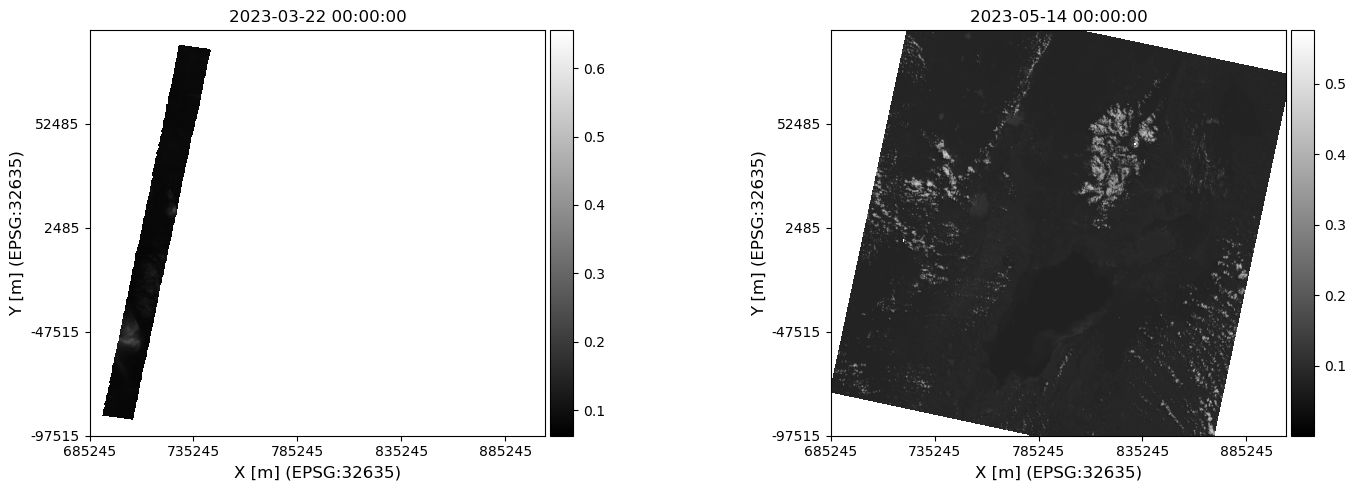

In [10]:
# the scenes can be plotted
f_scenes = mapper.data.plot(['red'], figsize=(15,5))

In [11]:
# make the SceneCollection obtained persistent so that we do not have to re-run
# the STAC query all the time we use the data.
fpath = Path('S:\MSc_23_TimckeFinn\data\EOdal\sample_mapper_data.pkl') #need to be adjusted to your drive letter
with open(fpath, 'wb+') as dst:
    dst.write(mapper.data.to_pickle())
